# Comparison of real HPL executions

In [1]:
import io
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['index'] = range(len(result))
    return result

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

executions = {
    'rennes_2019-08-01_1175987.zip' : 'consecutive',
    'rennes_2019-08-12_1178030.zip' : 'non-consecutive',
    'rennes_2019-08-14_1178378.zip' : 'consecutive:private',
    'rennes_2019-08-16_1179212.zip' : 'consecutive:private',
    'rennes_2019-08-18_1179242.zip' : 'consecutive:private',
    'rennes_2019-08-18_1179272.zip' : 'consecutive:private',    
}

dataframes = []
for archive, tag in executions.items():
    tmp = read_result(archive)
    tmp['tag'] = tag
    dataframes.append(tmp)
df = pandas.concat(dataframes)
df.head()

,bcast,block_size,depth,gflops,index,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,start_timestamp,stop_timestamp,swap,tag,thread_per_process,time
0,2,128,1,9650.0,0,175000,8,1,32,32,16,0.000763,2,2019-08-02 00:15:34.750189,2019-08-02 00:21:48.249940,0,consecutive,1,370.24
1,2,128,1,22010.0,1,500000,8,1,32,32,16,0.000586,2,2019-08-02 00:21:53.666398,2019-08-02 01:25:17.717936,0,consecutive,1,3785.88
2,2,128,1,1411.0,2,50000,8,1,32,32,16,0.001043,2,2019-08-02 01:25:26.150656,2019-08-02 01:26:26.894723,0,consecutive,1,59.05
3,2,128,1,16320.0,3,300000,8,1,32,32,16,0.000628,2,2019-08-02 01:26:32.340399,2019-08-02 01:45:03.050873,0,consecutive,1,1102.81
4,2,128,1,19670.0,4,400000,8,1,32,32,16,0.000565,2,2019-08-02 01:45:10.738360,2019-08-02 02:21:32.827248,0,consecutive,1,2168.83


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'matrix_size', 'tag', 'index', 'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,process_per_node,rfact,proc_q,swap,depth,mem_align,block_size,bcast,thread_per_process,proc_p,pfact
0,16,2,32,0,1,8,128,2,1,32,1


### Checking the OS version

In [3]:
for version_name in ['version', 'gcc', 'mpi', 'kernel', 'cpu']:
    for archive in executions.keys():
        versions = set()
        info = get_yaml(archive, 'info.yaml')
        hostnames = [key for key in info.keys() if key.startswith('paravance')]
        versions.update([info[h][version_name] for h in hostnames])
        assert len(versions) == 1
        print(versions.pop())
    print()

Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)

6.3.0
6.3.0
6.3.0
6.3.0
6.3.0
6.3.0

mpirun (Open MPI) 2.0.2
mpirun (

### Comparing the executions

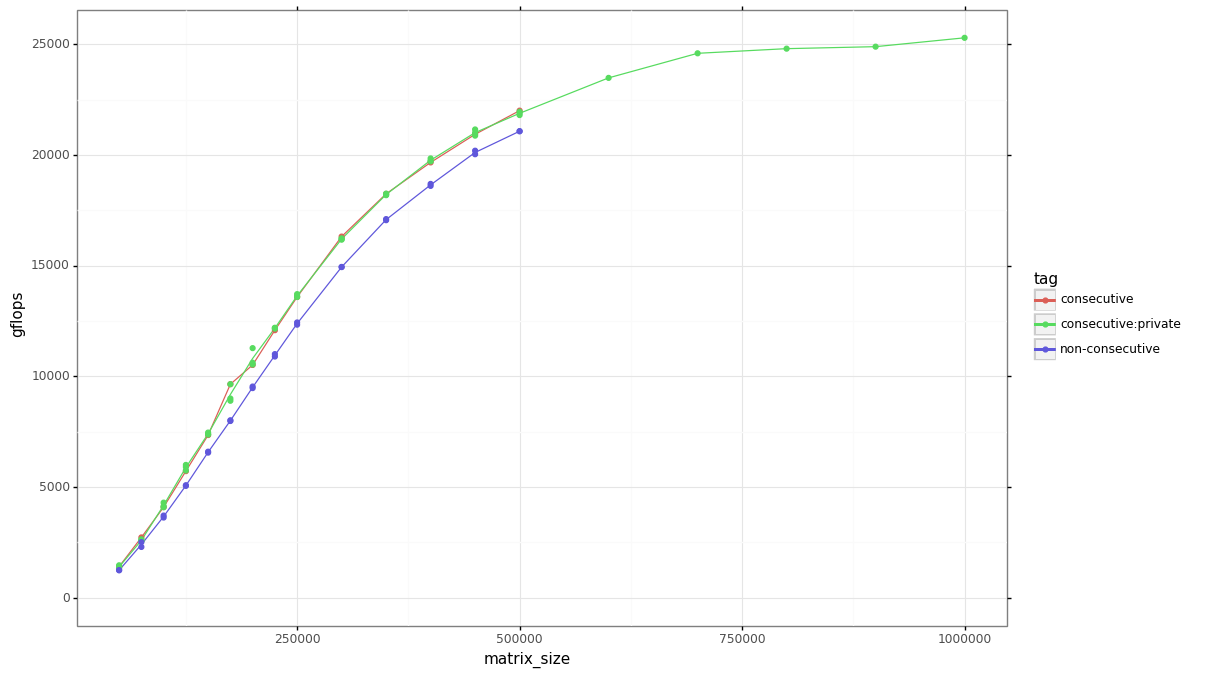

<ggplot: (-9223363293149777734)>

In [4]:
import numpy

ggplot(df, aes(x='matrix_size', y='gflops', color='tag')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

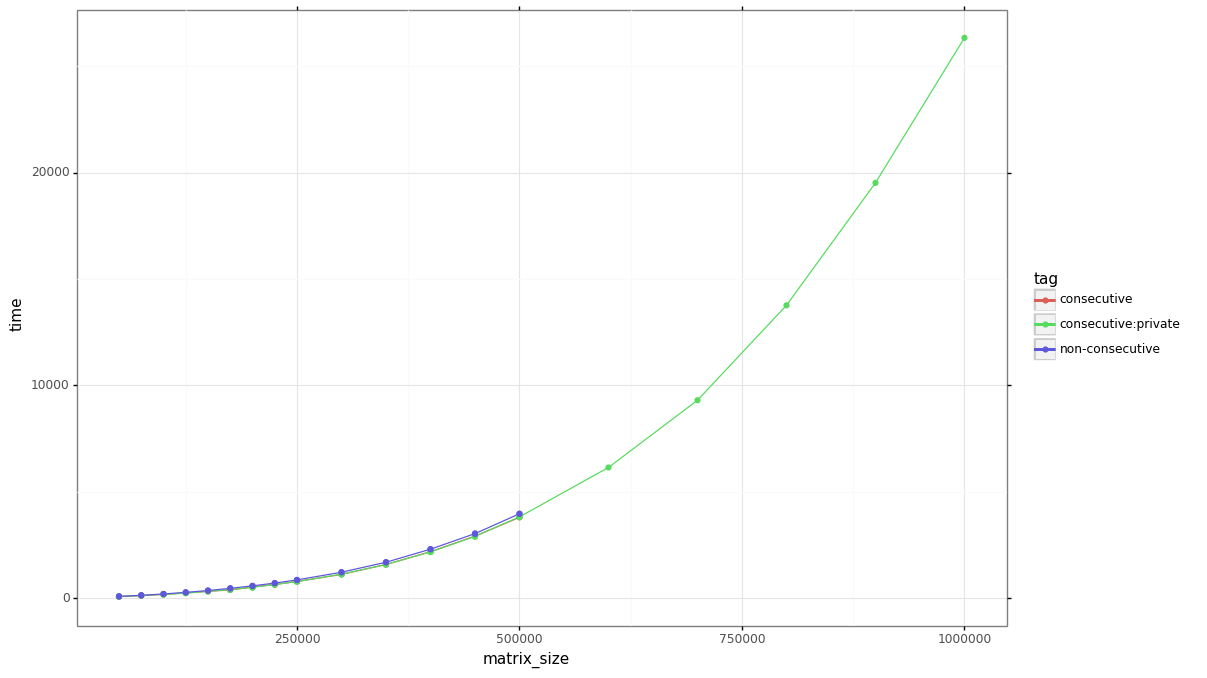

<ggplot: (8743704980158)>

In [5]:
ggplot(df, aes(x='matrix_size', y='time', color='tag')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)